# AI - CA #5 - Phase 1

## Majid Faridfar - 810199569

# MLP from scratch

In this notebook, I am to code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

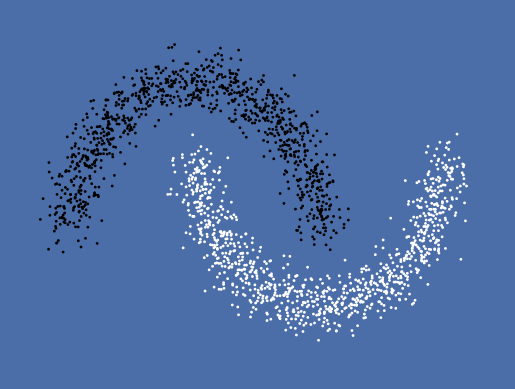

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [ ]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
  
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [ ]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        self.output = np.maximum(0, x)
        return self.output
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        self.grad_input = grad_output * (self.output > 0)
        return self.grad_input
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        pass

class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        self.output = 1./(1.+np.exp(-x))
        return self.output
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        sigmoid = self.output
        self.grad_input = grad_output * sigmoid * (1 - sigmoid)
        return self.grad_input
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        pass

Probably a good time to test your functions...

In [ ]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])

array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [ ]:
test_relu.backward(np.ones(6))

array([0., 0., 1., 0., 1., 1.])

In [ ]:
test_sig = MySigmoid()

test_sig.forward(np.ones(6)) # 1

array([0.73105858, 0.73105858, 0.73105858, 0.73105858, 0.73105858,
       0.73105858])

In [ ]:
test_sig.backward(np.ones(6)) # 1

array([0.19661193, 0.19661193, 0.19661193, 0.19661193, 0.19661193,
       0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [ ]:
from copy import deepcopy

class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        self.W = np.random.randn(n_input, n_output)
        self.b = np.random.randn(n_output)

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        self.x = deepcopy(x)

        self.output = np.dot(x, self.W) + self.b 
        return self.output

    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        dW = np.outer(self.x, grad_output)
        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        db = grad_output
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        dX = np.dot(grad_output, self.W.T)
        
        self.dW = dW
        self.db = db
        return dX

    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db

here we implement our network. note that with a Sigmoid layer, we use the Binary Cross Entropy (BCE) loss.

In [ ]:
class Sequential(object):
    def __init__(self, layers):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        self.layers = layers
        
    def forward(self, x):
        # apply the forward pass sequentially
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def compute_loss(self, out, label):
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        eps = 1e-10
        loss = - (label * np.log(out + eps) + (1 - label) * np.log(1 - out + eps))
        grad = - (label / (out + eps) - (1 - label) / (1 - out + eps))

        # save the gradient, and return the loss
        self.grad = grad
        return loss
    
    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        grad = self.grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return grad
        
    def step(self, learning_rate):
        # take a gradient step for each layer
        for layer in self.layers:
            layer.step(learning_rate)

In [ ]:
# define your network with your Sequential Class

layers = [MyLinear(2, 64),
          MyReLU(),
          MyLinear(64, 1),
          MySigmoid()]

network = Sequential(layers)

In [ ]:
losses = []
learning_rate = 1e-2
epochs = 20
for epoch in range(epochs):
    for it in range(len(X)):
        # pick a random example idx
        idx = np.random.randint(len(X))

        # select the corresponding example and label
        example = X[idx]
        label = Y[idx]

        # do a forward pass on the example
        out = network.forward(example)

        # compute the loss according to your output and the label
        loss = network.compute_loss(out, label)
        losses.append(loss)

        # backward pass
        grad = network.backward()

        # gradient step
        network.step(learning_rate)

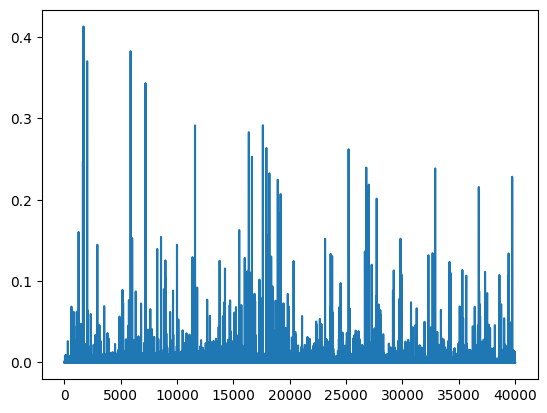

In [ ]:
%matplotlib inline
plt.plot(losses)
plt.show()

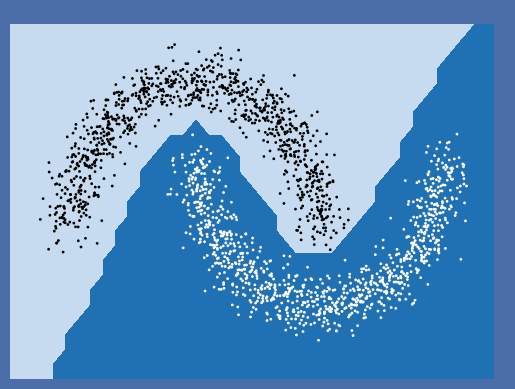

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, network)
fig.canvas.draw()

## 2. Load & Preprocess the IMDB Dataset

In this part, we work with the IMDB comments dataset. The dataset contains almost 50,000 user comments about IMDB movies. This dataset has two columns, `review` and `sentiment`. The review column contains the user's opinion and the sentiment column indicates whether the opinion is `positive` or `negative`.

For ease of work, we use the dataset as a `csv` file called `dataset_imdb.csv`. Due to its large size, I uploaded it to my drive and we read this file from there.

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
imdb_df = pd.read_csv('/content/drive/MyDrive/dataset/imdb_dataset.csv')

Mounted at /content/drive


In [ ]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


As you can see, this dataset contains two mentioned columns and 50000 entries.

Here you can see first 5 entries:

In [ ]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Also, more information about it is given below, using `describe()`:

In [ ]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Here you can see a random positive data and a random negative data.

In [ ]:
import random
pd.options.display.max_colwidth = 10000000000

positive = imdb_df[imdb_df['sentiment'] == 'positive']
print("A positive review:")
print(positive.sample()['review'].values[0])

print("----------------------------")

negative = imdb_df[imdb_df['sentiment'] == 'negative']
print("A negative review:")
print(negative.sample()['review'].values[0])

A positive review:
I showed this to my 6th grade class about 17 years ago and the students loved it. I loved it, too. The story of the termites and their interaction with their environment is amazing. The cast of creatures is deep and they all play their parts well. The battle between the two cold-blooded titans is truly classic footage.<br /><br />Alan Root has done some incredible camera work and this should have won the Best Documentary Oscar. The copy I have doesn't have Orson Welles narrating it (Derek Jacobi) and it isn't called the "Mysterious Castles of Clay," just "Castles of Clay." This makes me think that it must have been done with Welles added for star power and an Oscar push.<br /><br />I was lucky enough to find this VHS just recently and it is now my children's favorite movie. They brought it to the latest family gathering instead of a Disney movie. If you can find this movie you are indeed lucky.
----------------------------
A negative review:
If Jacqueline McKenzie an

First, we convert the `sentiment` column data into numerical data. For this, we use the `label encoding` method.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

imdb_df['sentiment'] = le.fit_transform(imdb_df['sentiment'])

In [ ]:
unique_values = imdb_df['sentiment'].unique()
print("Unique values:", unique_values, "\n")

imdb_df.info()

Unique values: [1 0] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


As you can see, the data type of is `int64` now (`0` or `1`).

Now we normalize the comments as much as possible. For this purpose, we use the `NLTK` (Natural Language Toolkit) library, which is one of the famous and powerful libraries in the field of text data processing and natural language. This library includes collections of tools and resources for Analyzing, processing and extracting information from natural language texts.

To do this, we use the following methods:
1. **Removing HTML tags and attributes** such as `<br/>`, using `BeautifulSoup` library.
2. **Removing unimportant characters** such as `'\n'` and `'\r'`, using regular expression (`re` module), and replace them with `space`.
3. **Converting the text to lowercase** using the `lower()` method.
4. **Removing punctuation** using a list comprehension and `string.punctuation`.
5. **Lemmatizing the words to their root form** using the `WordNetLemmatizer()` class from the `nltk` library.
6. **Removing stop words** (common words that do not carry much meaning) using the stopwords corpus from the `nltk` library.

As you can see below, we have written the `normalize_text` function that applies the mentioned methods to the input `text`. (note that in order to perform steps 3 and onward, we need to tokenize the text. To do this, we used the `word_tokenize` function). Finally, we apply this function to the `review` data column and generate a new `normalized_review` column in a copy of `imdb_df` dataset named `normalized_df`. 

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string
import re

def normalize_text(text):
    # Remove HTML tags and attributes
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Remove unimportant characters
    text = re.sub(r'[\n\r\t]', ' ', text.strip())
    
    # Convert the text to lowercase
    text = text.lower()
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove punctuation
    words = [word for word in words if word not in string.punctuation]
    
    # Lemmatize the words to their root form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

normalized_df = deepcopy(imdb_df)
normalized_df['review_normalized'] = imdb_df['review'].apply(normalize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-23-04f8f7b0567e>:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


### About word replacement by **Stemming** and **Lemmatization** methods

**Stemming**: Stemming is a process of reducing a word to its base or root form by removing the suffixes (endings) of the word. The resulting base form may not be a real word, but it retains the core meaning of the original word. For example, the stem of the word "running" is "run", and the stem of the word "jogging" is "jog". Stemming is a simple and computationally efficient method, but it may not always produce accurate results, as it does not take into account the context or meaning of the word.

**Lemmatization**: Lemmatization is a process of reducing a word to its base or root form by using a dictionary-based approach to map words to their base form. The resulting base form is a real word that has the same meaning as the original word. For example, the lemma of the word "ran" is "run", and the lemma of the word "jogged" is "jog". Lemmatization takes into account the context and meaning of the word, and can produce more accurate results than stemming, especially inlanguages with complex inflectional systems.

Since speed is not an issue for us at this stage, I have chosen the second method, which gives us more accurate results.


Now we will see a random data in the dataset to see what changes have occurred in the `review` column.

In [ ]:
import random
random_data = normalized_df.sample()

print("Before apply changes:")
print(random_data['review'].values[0])

print("\nAfter apply changes:")
print(random_data['review_normalized'].values[0])

Before apply changes:
Let start off by first saying that I have been a punk fan most of my life. I always kind of had a lack of respect for the LA scene of the early 80's, which The Decline of Western Civilization documents, with the exception of X and Black Flag, being more of New York and English punk guy. After I saw this movie that completely changed. The people shown may look like a bunch of idiotic, strung out kids who think they might accomplish something beyond street-Cree through their lifestyles, but it is a great display of hedonism at it's best, coupled with some fun, loud rock n roll. One of the best scenes, and actually most insightful, is the interview with Claude Bessy of Catholic Discipline, or 'Kick-Boy' as he was known to Slash magazine readers. Originally from France, he rants about punk like a dirty old Frenchman and clues in viewers to many aspects of the punk, or DIY, attitude to music, politics, and life in general. Darby Crash of the Germs comes off as a comple

### About TF-IDF method 

TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used in natural language processing (NLP) to represent the importance of words in a document or corpus. It is a statistical measure that combines two metrics: **term frequency (TF)** and **inverse document frequency (IDF)**.

* **TF** measures the frequency of a word in a document, and is calculated by *dividing the number of times a word appears in a document by the total number of words in the document*. The idea behind TF is that words that appear more frequently in a document are more important to the meaning of the document.

* **IDF** measures the rarity of a word in a corpus, and is calculated by *taking the logarithm of the total number of documents in the corpus divided by the number of documents that contain the word*. The idea behind IDF is that words that appear in fewer documents are more important to the meaning of the corpus, as they provide more information about the specific topics or themes covered by the documents that contain them.

The TF-IDF score for a word in a document is calculated by *multiplying the TF and IDF scores*. This results in a score that represents how important the word is to the document, relative to its importance in the corpus as a whole. Words with high TF-IDF scores are considered to be more important to the meaning of the document, and can be used in various NLP tasks such as text classification and information retrieval.



Using `TfidfVectorizer`, we can extract these features and the corresponding weights, based on the mentioned method, from the `normalized_review` column of `normalized_df`. (The results are stored in `tfidf_matrix`)

Note: By default, TfidfVectorizer considers all the words in the data as features, and weights the words for different sentences and the number of repetitions of words in each sentence. But a large number of words are very infrequent and less important in model training. As a result, to reduce memory consumption and calculations, we set the `features_max` argument to $5000$.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(normalized_df['review_normalized'])

Now we convert the given matrix (`tfidf_matrix`) into a data frame (`tfidf_df`) and add the target column (`sentiment`) to it.

In [ ]:
feature_names = vectorizer.vocabulary_.keys()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['sentiment'] = normalized_df['sentiment']

In [ ]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 5000 entries, one to bettie
dtypes: float64(4999), int64(1)
memory usage: 1.9 GB


As you can see, now we have $5000$ data columns (as we determined), which are the words, and $50000$ entries.

Note: One of the columns is `sentiment`, which is 0 or 1.

More information is provided below, using `describe()` method:

In [ ]:
tfidf_df.describe()

,one,reviewer,ha,mentioned,watching,oz,episode,ll,hooked,right,...,wisdom,virtual,underwater,titanic,mildred,miike,minister,critter,garfield,bettie
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.000508,0.001073,0.010902,0.001790,0.001296,0.001373,0.001163,0.000465,0.000812,0.002003,...,0.000577,0.006462,0.002272,0.001668,0.008108,0.001829,0.001161,0.001411,0.003288,0.000671
std,0.009538,0.013193,0.033135,0.015607,0.015081,0.013719,0.013095,0.008535,0.011075,0.016074,...,0.009593,0.023144,0.017341,0.014861,0.027457,0.014891,0.013075,0.014607,0.033740,0.010610
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.483479,0.585102,0.528797,0.567493,0.635995,0.433354,0.485154,0.383354,0.419714,0.396429,...,0.355091,0.392974,0.610790,0.616228,0.461104,0.334212,0.641164,0.639494,0.764852,0.497261


Now we divide our preprocessed data (`tfidf_df`), to two parts. One for `train` ($80$%) and one for `test` ($20$%).

In [ ]:
test_percentage = 0.2

test_data = tfidf_df[0:int(test_percentage*len(tfidf_df))]
train_data = tfidf_df[int(test_percentage*len(tfidf_df)):len(tfidf_df)]

Now let's check that before giving the input to the neural network, the value of each feature is between 0 and 1.

In [ ]:
df_describe = tfidf_df.describe()

if (df_describe.loc['min'] >= 0).all() and (df_describe.loc['max'] <= 1).all():
  print("Values of all features are between 0 and 1.")
else:
  print("There are some features with values less than 0 or grater than 1.")

Values of all features are between 0 and 1.


### If not, what would happen?

If the input features have a large range of values,

1. **Gradient explosion or vanishing**: The gradients used in the backpropagation algorithm can become very large or very small. This can cause the gradients to "explode" or "vanish", making it difficult or impossible for the neural network to learn from the data.

2. **Slow convergence**: The learning rate used in the training process may need to be very small to ensure stable convergence. This can cause the training process to be slow and inefficient.

3. **Bias in weight updates**: Some features may dominate others in the weight updates during training. This can cause the neural network to be biased towards certain features.

4. **Overfitting**: The neural network may learn to fit the training data too well, resulting in overfitting.

Now we calculate the number of comments in each category for the train and test datasets and draw a bar graph for them.

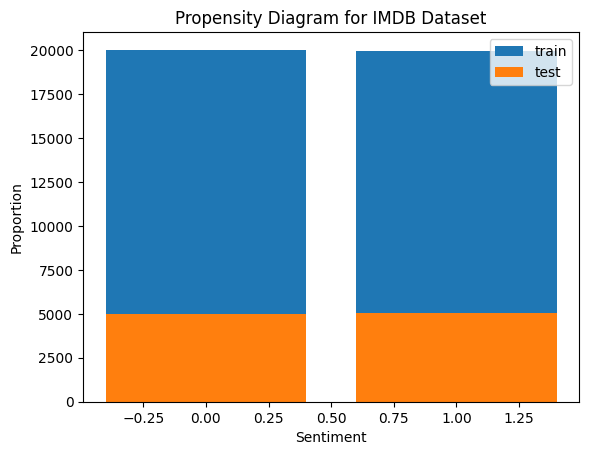

In [ ]:
# Group the data by sentiment and count the number of rows in each group for the train set
train_counts = train_data.groupby('sentiment').count()['comment']

# Group the data by sentiment and count the number of rows in each group for the test set
test_counts = test_data.groupby('sentiment').count()['comment']

# Plot the propensity diagram
plt.bar(train_counts.index, train_counts, label='train')
plt.bar(test_counts.index, test_counts, label='test')
plt.title('Propensity Diagram for IMDB Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.legend()
plt.show()

## 3.2. MLP in torch

In [ ]:
import torch
import torch.nn as nn

# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        self.A = nn.Parameter(torch.randn(n_output, n_input))
        self.b = nn.Parameter(torch.randn(n_output))

    def forward(self, x):
        linear_output = torch.matmul(x, self.A.t()) + self.b
        return linear_output
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        # apply ReLU activation function to input tensor x
        relu_output = torch.clamp(x, min=0)
        return relu_output

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [ ]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

def generate_data_loader(train_data, test_data, batch_size):
  X_train = torch.Tensor(train_data.drop('sentiment', axis=1).values)
  y_train = torch.Tensor(train_data['sentiment'].values)
  X_test = torch.Tensor(test_data.drop('sentiment', axis=1).values)
  y_test = torch.Tensor(test_data['sentiment'].values)

  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader


We know that we have $4999$ columns for words, which will be the input features of the model (in input layer). Also, among the few values I tried, $32$ neurons gave good results for Hayden Lear. The output layer also has a neuron (which classifies the input).

In [ ]:
input_size = 4999
hidden_size = 32
output_size = 1

In this function, we first create a model with three layers, which uses the given activation_function as input. Then, using the given batch_size, we make test and training data loaders. Then we train the model 40-50 times (with feed forward and back propagation) and then test it on the test data and get the accuracy. Finally, we draw the most graphed Las and get the l, Precision, Accuracy and 1-F metrics for it.

In [ ]:
from torch import optim
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

def test_model(learning_rate, activation_function, batch_size):
  # define your network with nn.Sequential
  # use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)
  model = nn.Sequential(
      MyLinear_mod(input_size, hidden_size),
      activation_function(),
      MyLinear_mod(hidden_size, hidden_size),
      activation_function(),
      nn.Linear(hidden_size, output_size),
      nn.Sigmoid()
  )

  train_loader, test_loader = generate_data_loader(train_data, test_data, batch_size)
  
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)

  losses = []
  criterion = nn.BCELoss()
  epochs = 40

  # Train the model using train_loader
  for epoch in range(epochs):
      train_loss = 0.0
      for batch in train_loader:
          # Get the inputs and labels from the batch
          inputs, labels = batch
          labels = labels.view(-1, 1)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute the loss
          loss = criterion(outputs, labels)

          # Backward pass
          loss.backward()

          # Gradient step
          optimizer.step()

          # Add the batch loss to the total loss for this epoch
          train_loss += loss.item()

      # Compute the average loss for this epoch
      train_loss /= len(train_loader)

      # Compute the test loss and accuracy for this epoch
      correct = 0
      total = 0

      y_true = []
      y_pred = []

      with torch.no_grad():
          for batch in test_loader:
              # Get the inputs and labels from the batch
              inputs, labels = batch
              labels = labels.view(-1, 1)

              # Forward pass
              outputs = model(inputs)

              # Compute the predicted labels
              predicted = torch.round(outputs)

              # Append true and predicted labels to y_true and y_pred lists
              y_true += labels.squeeze().tolist()
              y_pred += predicted.squeeze().tolist()

              # Compute the number of correct predictions
              correct += (predicted == labels).sum().item()

              # Compute the total number of predictions
              total += labels.size(0)

      # Compute accuracy for this epoch
      accuracy = correct / total

      # Print the epoch number, train loss, test loss, and test accuracy
      print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Accuracy = {accuracy:.4f}")

      # Save the train loss for plotting
      losses.append(train_loss)

  print("------------------------------------------------------------")
  lb = LabelBinarizer()
  lb.fit(y_true)
  print(classification_report(lb.transform(y_true), lb.transform(y_pred)))
  print("------------------------------------------------------------")
  plt.plot(losses)



Here you can see the results for a model with the following attributes.

Epoch 1/50: Train Loss = 0.7494, Accuracy = 0.5387
Epoch 2/50: Train Loss = 0.6968, Accuracy = 0.5515
Epoch 3/50: Train Loss = 0.6889, Accuracy = 0.5390
Epoch 4/50: Train Loss = 0.6824, Accuracy = 0.5686
Epoch 5/50: Train Loss = 0.6750, Accuracy = 0.5867
Epoch 6/50: Train Loss = 0.6657, Accuracy = 0.6088
Epoch 7/50: Train Loss = 0.6559, Accuracy = 0.6179
Epoch 8/50: Train Loss = 0.6447, Accuracy = 0.6300
Epoch 9/50: Train Loss = 0.6324, Accuracy = 0.6466
Epoch 10/50: Train Loss = 0.6198, Accuracy = 0.6649
Epoch 11/50: Train Loss = 0.6060, Accuracy = 0.6779
Epoch 12/50: Train Loss = 0.5927, Accuracy = 0.6820
Epoch 13/50: Train Loss = 0.5792, Accuracy = 0.7041
Epoch 14/50: Train Loss = 0.5659, Accuracy = 0.7093
Epoch 15/50: Train Loss = 0.5532, Accuracy = 0.7223
Epoch 16/50: Train Loss = 0.5397, Accuracy = 0.7308
Epoch 17/50: Train Loss = 0.5277, Accuracy = 0.7384
Epoch 18/50: Train Loss = 0.5159, Accuracy = 0.7466
Epoch 19/50: Train Loss = 0.5046, Accuracy = 0.7555
Epoch 20/50: Train Lo

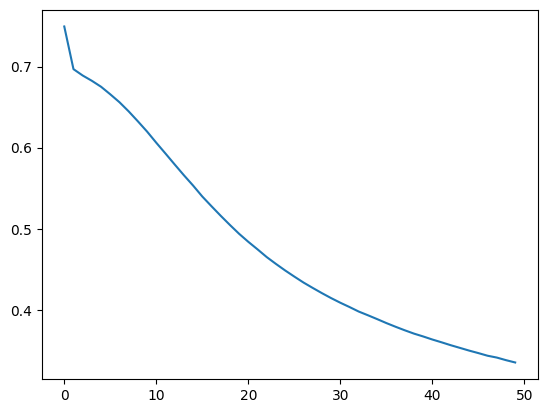

In [ ]:
test_model(learning_rate = 0.1,
           activation_function = MyReLU_mod,
           batch_size = 32)

### If the initial value of all network weights was zero and you trained the network, what would be the results?
If the initial values of all network weights are set to zero, then all the neurons in the network would produce the same output, resulting in a lack of diversity in the network's output. This would occur because the gradients computed during backpropagation would be the same for all weights, and therefore all weights would be updated by the same amount at each iteration of training.

As a result, the network would fail to learn the underlying patterns in the data, and its performance would be poor. Specifically, the network would not be able to represent complex functions and would not be able to capture the non-linearities present in the data.

Therefore, it is important to initialize the weights of a neural network with small random values, such as with the Glorot or He initialization methods, to break the symmetry and allow the network to learn the underlying patterns in the data and make progress during training.

### 3. Effect of **Learning Rate**

Here we have examined four learning rates of $0.01$, $0.1$, $0.5$ and $1$.

#### Learning Rate = $0.01$

Epoch 1/50: Train Loss = 0.7213, Accuracy = 0.5193
Epoch 2/50: Train Loss = 0.7030, Accuracy = 0.5631
Epoch 3/50: Train Loss = 0.6970, Accuracy = 0.5703
Epoch 4/50: Train Loss = 0.6930, Accuracy = 0.5696
Epoch 5/50: Train Loss = 0.6877, Accuracy = 0.5673
Epoch 6/50: Train Loss = 0.6859, Accuracy = 0.5835
Epoch 7/50: Train Loss = 0.6832, Accuracy = 0.5869
Epoch 8/50: Train Loss = 0.6822, Accuracy = 0.5905
Epoch 9/50: Train Loss = 0.6794, Accuracy = 0.5629
Epoch 10/50: Train Loss = 0.6775, Accuracy = 0.5909
Epoch 11/50: Train Loss = 0.6762, Accuracy = 0.5879
Epoch 12/50: Train Loss = 0.6734, Accuracy = 0.5794
Epoch 13/50: Train Loss = 0.6736, Accuracy = 0.5944
Epoch 14/50: Train Loss = 0.6705, Accuracy = 0.5809
Epoch 15/50: Train Loss = 0.6691, Accuracy = 0.5855
Epoch 16/50: Train Loss = 0.6675, Accuracy = 0.6001
Epoch 17/50: Train Loss = 0.6673, Accuracy = 0.6050
Epoch 18/50: Train Loss = 0.6651, Accuracy = 0.5877
Epoch 19/50: Train Loss = 0.6640, Accuracy = 0.5649
Epoch 20/50: Train Lo

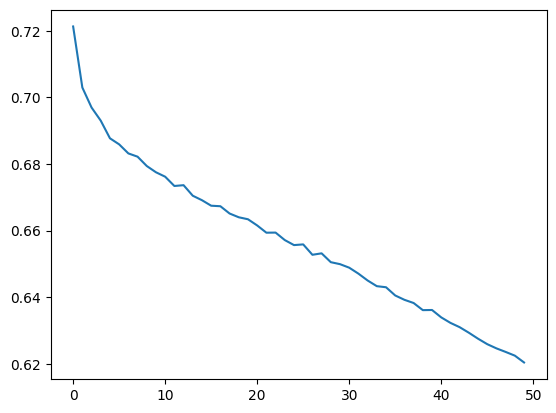

In [ ]:
test_model(learning_rate = 0.01,
           activation_function = MyReLU_mod,
           batch_size = 32)

#### Learning Rate = $0.1$

Epoch 1/50: Train Loss = 0.7494, Accuracy = 0.5387
Epoch 2/50: Train Loss = 0.6968, Accuracy = 0.5515
Epoch 3/50: Train Loss = 0.6889, Accuracy = 0.5390
Epoch 4/50: Train Loss = 0.6824, Accuracy = 0.5686
Epoch 5/50: Train Loss = 0.6750, Accuracy = 0.5867
Epoch 6/50: Train Loss = 0.6657, Accuracy = 0.6088
Epoch 7/50: Train Loss = 0.6559, Accuracy = 0.6179
Epoch 8/50: Train Loss = 0.6447, Accuracy = 0.6300
Epoch 9/50: Train Loss = 0.6324, Accuracy = 0.6466
Epoch 10/50: Train Loss = 0.6198, Accuracy = 0.6649
Epoch 11/50: Train Loss = 0.6060, Accuracy = 0.6779
Epoch 12/50: Train Loss = 0.5927, Accuracy = 0.6820
Epoch 13/50: Train Loss = 0.5792, Accuracy = 0.7041
Epoch 14/50: Train Loss = 0.5659, Accuracy = 0.7093
Epoch 15/50: Train Loss = 0.5532, Accuracy = 0.7223
Epoch 16/50: Train Loss = 0.5397, Accuracy = 0.7308
Epoch 17/50: Train Loss = 0.5277, Accuracy = 0.7384
Epoch 18/50: Train Loss = 0.5159, Accuracy = 0.7466
Epoch 19/50: Train Loss = 0.5046, Accuracy = 0.7555
Epoch 20/50: Train Lo

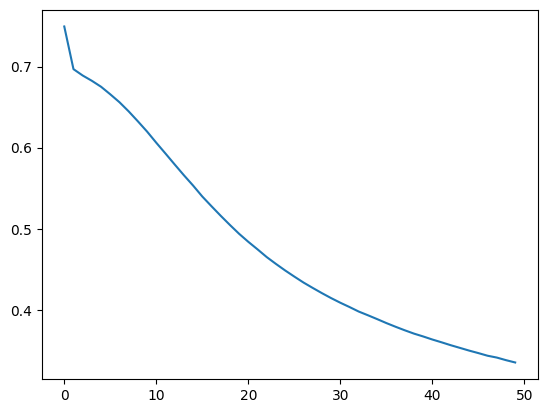

In [ ]:
test_model(learning_rate = 0.1,
           activation_function = MyReLU_mod,
           batch_size = 32)

#### Learning Rate = $0.5$

Epoch 1/50: Train Loss = 0.7606, Accuracy = 0.5900
Epoch 2/50: Train Loss = 0.6577, Accuracy = 0.6717
Epoch 3/50: Train Loss = 0.5819, Accuracy = 0.7422
Epoch 4/50: Train Loss = 0.5040, Accuracy = 0.7346
Epoch 5/50: Train Loss = 0.4504, Accuracy = 0.8021
Epoch 6/50: Train Loss = 0.4120, Accuracy = 0.8173
Epoch 7/50: Train Loss = 0.3848, Accuracy = 0.8165
Epoch 8/50: Train Loss = 0.3636, Accuracy = 0.8389
Epoch 9/50: Train Loss = 0.3461, Accuracy = 0.8482
Epoch 10/50: Train Loss = 0.3315, Accuracy = 0.8507
Epoch 11/50: Train Loss = 0.3193, Accuracy = 0.8507
Epoch 12/50: Train Loss = 0.3082, Accuracy = 0.8589
Epoch 13/50: Train Loss = 0.3000, Accuracy = 0.8557
Epoch 14/50: Train Loss = 0.2896, Accuracy = 0.8623
Epoch 15/50: Train Loss = 0.2789, Accuracy = 0.8669
Epoch 16/50: Train Loss = 0.2729, Accuracy = 0.8639
Epoch 17/50: Train Loss = 0.2642, Accuracy = 0.8679
Epoch 18/50: Train Loss = 0.2569, Accuracy = 0.8652
Epoch 19/50: Train Loss = 0.2497, Accuracy = 0.8689
Epoch 20/50: Train Lo

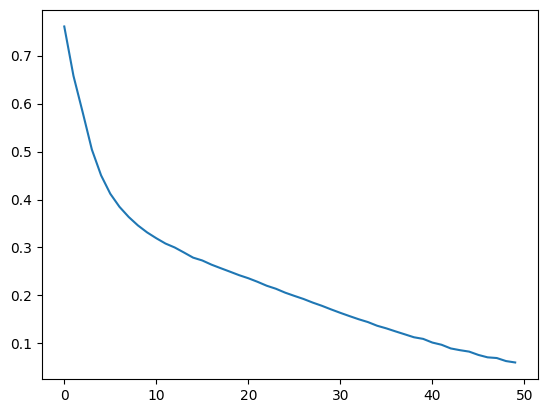

In [ ]:
test_model(learning_rate = 0.6,
           activation_function = MyReLU_mod,
           batch_size = 32)

#### Learning Rate = $1$

Epoch 1/50: Train Loss = 1.2086, Accuracy = 0.5815
Epoch 2/50: Train Loss = 0.6768, Accuracy = 0.6437
Epoch 3/50: Train Loss = 0.6177, Accuracy = 0.7207
Epoch 4/50: Train Loss = 0.4981, Accuracy = 0.7785
Epoch 5/50: Train Loss = 0.4254, Accuracy = 0.8077
Epoch 6/50: Train Loss = 0.3841, Accuracy = 0.8354
Epoch 7/50: Train Loss = 0.3567, Accuracy = 0.8384
Epoch 8/50: Train Loss = 0.3338, Accuracy = 0.8557
Epoch 9/50: Train Loss = 0.3140, Accuracy = 0.8514
Epoch 10/50: Train Loss = 0.2997, Accuracy = 0.8561
Epoch 11/50: Train Loss = 0.2873, Accuracy = 0.8655
Epoch 12/50: Train Loss = 0.2768, Accuracy = 0.8677
Epoch 13/50: Train Loss = 0.2643, Accuracy = 0.8714
Epoch 14/50: Train Loss = 0.2546, Accuracy = 0.8703
Epoch 15/50: Train Loss = 0.2444, Accuracy = 0.8736
Epoch 16/50: Train Loss = 0.2337, Accuracy = 0.8721
Epoch 17/50: Train Loss = 0.2260, Accuracy = 0.8723
Epoch 18/50: Train Loss = 0.2170, Accuracy = 0.8682
Epoch 19/50: Train Loss = 0.2079, Accuracy = 0.8755
Epoch 20/50: Train Lo

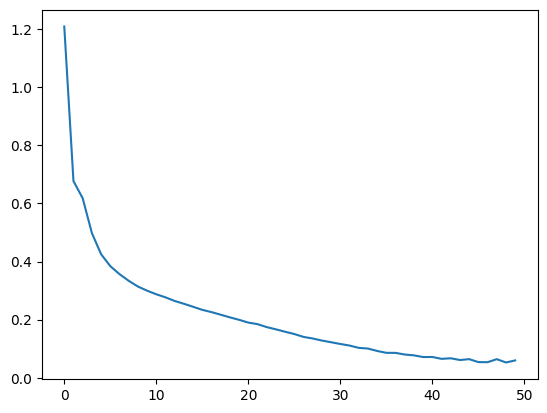

In [ ]:
test_model(learning_rate = 1,
           activation_function = MyReLU_mod,
           batch_size = 32)

Based on the results, it appears that the model performs better with higher learning rates. A higher learning rate can help the model converge faster towards a good solution. However, it is important to note that using a very high learning rate can cause the model to overshoot the optimal solution and diverge.

In this case, the accuracy of the model increases as the learning rate increases from 0.01 to 1, which suggests that the optimal learning rate for this model lies somewhere between 0.5 and 1.0 (I choosed 1, for the next steps). However, it is possible that the model may perform differently on other datasets or with different architectures.

#### 4. Effect of **Activation Functions**

#### Sigmoid


Epoch 1/50: Train Loss = 0.6637, Accuracy = 0.6851
Epoch 2/50: Train Loss = 0.5366, Accuracy = 0.7749
Epoch 3/50: Train Loss = 0.4420, Accuracy = 0.8107
Epoch 4/50: Train Loss = 0.3915, Accuracy = 0.8281
Epoch 5/50: Train Loss = 0.3574, Accuracy = 0.8409
Epoch 6/50: Train Loss = 0.3337, Accuracy = 0.8506
Epoch 7/50: Train Loss = 0.3160, Accuracy = 0.8582
Epoch 8/50: Train Loss = 0.3012, Accuracy = 0.8646
Epoch 9/50: Train Loss = 0.2875, Accuracy = 0.8674
Epoch 10/50: Train Loss = 0.2780, Accuracy = 0.8693
Epoch 11/50: Train Loss = 0.2686, Accuracy = 0.8689
Epoch 12/50: Train Loss = 0.2609, Accuracy = 0.8746
Epoch 13/50: Train Loss = 0.2542, Accuracy = 0.8788
Epoch 14/50: Train Loss = 0.2479, Accuracy = 0.8782
Epoch 15/50: Train Loss = 0.2412, Accuracy = 0.8758
Epoch 16/50: Train Loss = 0.2366, Accuracy = 0.8737
Epoch 17/50: Train Loss = 0.2316, Accuracy = 0.8796
Epoch 18/50: Train Loss = 0.2271, Accuracy = 0.8814
Epoch 19/50: Train Loss = 0.2218, Accuracy = 0.8789
Epoch 20/50: Train Lo

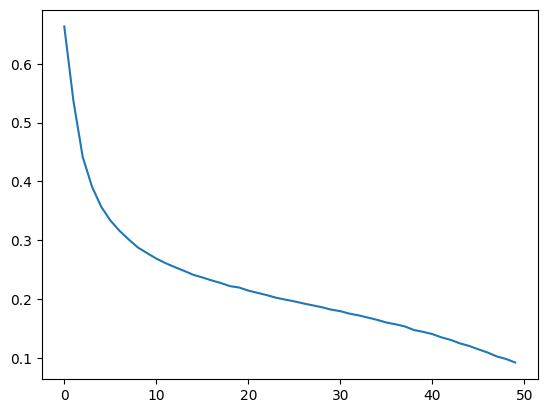

In [ ]:
test_model(learning_rate = 1,
           activation_function = nn.Sigmoid,
           batch_size = 32)

#### Hyperbolic Tangent

Epoch 1/40: Train Loss = 0.7135, Accuracy = 0.6743
Epoch 2/40: Train Loss = 0.5739, Accuracy = 0.7490
Epoch 3/40: Train Loss = 0.4769, Accuracy = 0.7924
Epoch 4/40: Train Loss = 0.4165, Accuracy = 0.8164
Epoch 5/40: Train Loss = 0.3779, Accuracy = 0.8355
Epoch 6/40: Train Loss = 0.3500, Accuracy = 0.8395
Epoch 7/40: Train Loss = 0.3244, Accuracy = 0.8510
Epoch 8/40: Train Loss = 0.3026, Accuracy = 0.8399
Epoch 9/40: Train Loss = 0.2869, Accuracy = 0.8563
Epoch 10/40: Train Loss = 0.2699, Accuracy = 0.8604
Epoch 11/40: Train Loss = 0.2563, Accuracy = 0.8601
Epoch 12/40: Train Loss = 0.2407, Accuracy = 0.8620
Epoch 13/40: Train Loss = 0.2261, Accuracy = 0.8604
Epoch 14/40: Train Loss = 0.2128, Accuracy = 0.8663
Epoch 15/40: Train Loss = 0.1985, Accuracy = 0.8617
Epoch 16/40: Train Loss = 0.1819, Accuracy = 0.8614
Epoch 17/40: Train Loss = 0.1665, Accuracy = 0.8629
Epoch 18/40: Train Loss = 0.1477, Accuracy = 0.8631
Epoch 19/40: Train Loss = 0.1338, Accuracy = 0.8548
Epoch 20/40: Train Lo

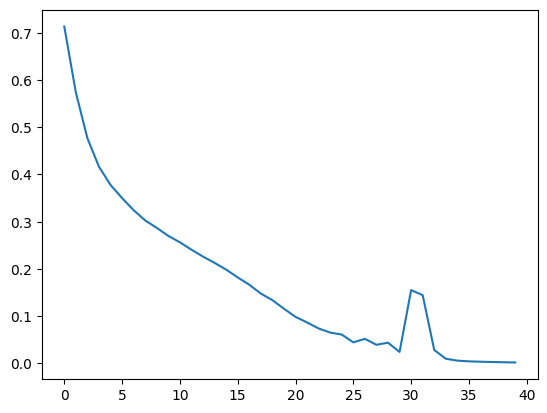

In [ ]:
test_model(learning_rate = 1,
           activation_function = nn.Tanh,
           batch_size = 32)

#### Leaky ReLU

Epoch 1/40: Train Loss = 0.6999, Accuracy = 0.6061
Epoch 2/40: Train Loss = 0.6246, Accuracy = 0.7138
Epoch 3/40: Train Loss = 0.5164, Accuracy = 0.7464
Epoch 4/40: Train Loss = 0.4425, Accuracy = 0.8196
Epoch 5/40: Train Loss = 0.3855, Accuracy = 0.8349
Epoch 6/40: Train Loss = 0.3529, Accuracy = 0.8445
Epoch 7/40: Train Loss = 0.3303, Accuracy = 0.8548
Epoch 8/40: Train Loss = 0.3120, Accuracy = 0.8626
Epoch 9/40: Train Loss = 0.2984, Accuracy = 0.8679
Epoch 10/40: Train Loss = 0.2866, Accuracy = 0.8633
Epoch 11/40: Train Loss = 0.2760, Accuracy = 0.8730
Epoch 12/40: Train Loss = 0.2681, Accuracy = 0.8744
Epoch 13/40: Train Loss = 0.2614, Accuracy = 0.8782
Epoch 14/40: Train Loss = 0.2540, Accuracy = 0.8769
Epoch 15/40: Train Loss = 0.2479, Accuracy = 0.8774
Epoch 16/40: Train Loss = 0.2432, Accuracy = 0.8818
Epoch 17/40: Train Loss = 0.2382, Accuracy = 0.8804
Epoch 18/40: Train Loss = 0.2334, Accuracy = 0.8792
Epoch 19/40: Train Loss = 0.2293, Accuracy = 0.8790
Epoch 20/40: Train Lo

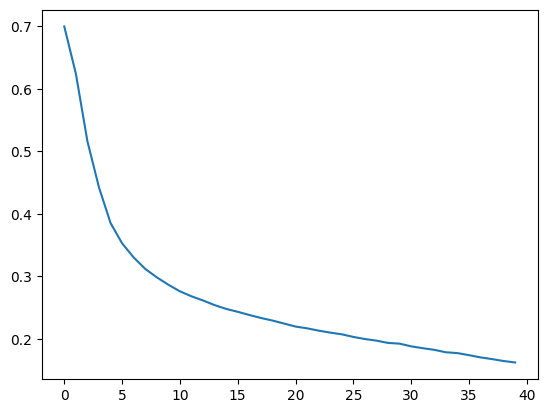

In [ ]:
test_model(learning_rate = 1,
           activation_function = nn.LeakyReLU,
           batch_size = 32)

#### ReLU

Epoch 1/50: Train Loss = 1.2086, Accuracy = 0.5815
Epoch 2/50: Train Loss = 0.6768, Accuracy = 0.6437
Epoch 3/50: Train Loss = 0.6177, Accuracy = 0.7207
Epoch 4/50: Train Loss = 0.4981, Accuracy = 0.7785
Epoch 5/50: Train Loss = 0.4254, Accuracy = 0.8077
Epoch 6/50: Train Loss = 0.3841, Accuracy = 0.8354
Epoch 7/50: Train Loss = 0.3567, Accuracy = 0.8384
Epoch 8/50: Train Loss = 0.3338, Accuracy = 0.8557
Epoch 9/50: Train Loss = 0.3140, Accuracy = 0.8514
Epoch 10/50: Train Loss = 0.2997, Accuracy = 0.8561
Epoch 11/50: Train Loss = 0.2873, Accuracy = 0.8655
Epoch 12/50: Train Loss = 0.2768, Accuracy = 0.8677
Epoch 13/50: Train Loss = 0.2643, Accuracy = 0.8714
Epoch 14/50: Train Loss = 0.2546, Accuracy = 0.8703
Epoch 15/50: Train Loss = 0.2444, Accuracy = 0.8736
Epoch 16/50: Train Loss = 0.2337, Accuracy = 0.8721
Epoch 17/50: Train Loss = 0.2260, Accuracy = 0.8723
Epoch 18/50: Train Loss = 0.2170, Accuracy = 0.8682
Epoch 19/50: Train Loss = 0.2079, Accuracy = 0.8755
Epoch 20/50: Train Lo

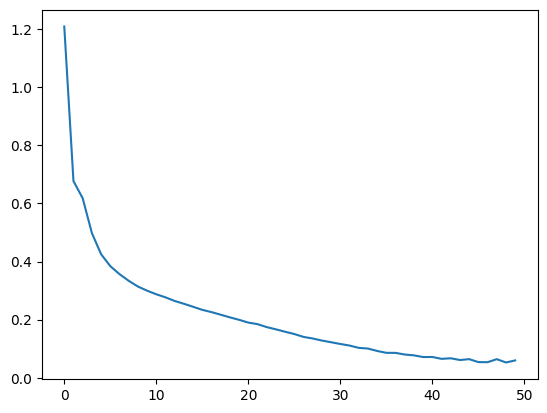

In [ ]:
test_model(learning_rate = 1,
           activation_function = MyReLU_mod,
           batch_size = 32)

As you can see, the accuracy of Leaky ReLU and Sigmoid are greater that Tanh and ReLU's.

#### Why Tanh and Sigmoid functions are generally not a good choice to use in hidden layers?
The Tanh and Sigmoid activation functions are generally not a good choice to use in hidden layers of neural networks because of a property known as "vanishing gradients".

The Tanh and Sigmoid functions both saturate at high or low values, meaning that their gradients become very small when the input is far away from zero. As a result, during backpropagation, the gradients get smaller and smaller as they propagate backwards through the network, and this can cause the gradients to "vanish" to zero as they reach the early layers of the network.

When this happens, the early layers of the network do not get updated effectively, and the network fails to learn the underlying patterns in the data. This problem is particularly severe in deep neural networks with many layers, where the vanishing gradients problem can become exponentially worse as the gradients propagate backwards through the network.

In contrast, activation functions such as ReLU and its variants do not suffer from the vanishing gradients problem. They have a constant gradient for positive inputs, which helps to propagate the gradients effectively through the network during backpropagation, and they can therefore be more effective in deep neural networks.

There are other reasons why Tanh and Sigmoid functions are not commonly used in hidden layers. For example, the Tanh function has a negative range, which means that it can produce negative outputs, and this can be a problem in some applications. Sigmoid functions are also prone to saturation when their inputs are large, which can cause the gradients tovanish.

#### What is the difference and superiority of ReLU Leaky compared to ReLU?

The main difference between these two is that the Leaky ReLU allows for a small non-zero gradient when the input is negative, while the ReLU has a gradient of zero for negative inputs.

The ReLU activation function is defined as:
$$f(x) = max(0, x)$$


The Leaky ReLU activation function is defined as:
$$f(x) = max(ax, x)$$


where a is a small positive constant, typically set to 0.01.

The Leaky ReLU was introduced to address the "dying ReLU" problem, which occurs when a large number of neurons in a network become inactive and produce zero output. This can happen when the gradients become zero during training, effectively "killing" the ReLU neurons. In contrast, the Leaky ReLU allows for a small non-zero gradient when the input is negative, which can help to prevent the "dying ReLU" problem and improve the performance of the network.

In general, the Leaky ReLU is preferred over the ReLU because it can help to improve the performance of deep neural networks by preventing the "dying ReLU" problem. However, it is worth noting that the choice of activation function can depend on the specific task and architecture, and it is always important to experiment with different activation functions to find the best onefor a given problem.

### Effect of **Batch**

#### What is the reason for using batch in the training process? Describe the advantages and disadvantages of very small and very large batch sizes.

Batch training is a common technique used in machine learning to update the weights of a model based on a subset of the training data, rather than the entire dataset at once. The main reason for using batch training is to improve the efficiency of the training process by reducing the memory requirements and computational cost of processing large datasets.

Advantages of Small Batch Sizes:

* Smaller batch sizes can help to reduce the memory requirements of the training process, which can be especially important when working with large datasets or complex models.
* Small batch sizes can help to reduce overfitting by adding more noise to the weight updates and preventing the model from memorizing the training data.
* Small batch sizes can help to speed up the convergence of the training process by allowing the model to update its weights more frequently, which can be particularly useful in the early stages of training.

Disadvantages of Small Batch Sizes:

* Smaller batch sizes can increase the variance of the weight updates, which can make the training process less stable and lead to slower convergence.
* Small batch sizes can be less efficient when working with parallel processing architectures, as the overhead of communication between processors can become significant.

Advantages of Large Batch Sizes:

* Larger batch sizes can help to reduce the variance of the weight updates, which can lead to more stable training and faster convergence.
* Large batch sizes can be more efficient when working with parallel processing architectures, as the overhead of communication between processors can be reduced.
* Large batch sizes can help to reduce the impactof noise in the weight updates, which can be useful when working with noisy data or models that are prone to overfitting.

Disadvantages of Large Batch Sizes:

* Larger batch sizes can increase the memory requirements and computational cost of the training process, which can be especially problematic when working with large datasets or complex models.
* Large batch sizes can lead to slower convergence in the early stages of training, as the model may not update its weights frequently enough to learn the underlying patterns in the data.
* Large batch sizes can increase the risk of overfitting, as the weight updates may be too smooth and fail to capture the nuances of the training data.

In practice, the choice of batch size depends on a variety of factors, including the size and complexity of the dataset, the architecture of the model, and the available computational resources. A common approach is to experiment with a range of batch sizes and select the one that achieves the best performance on a validation set.

Here I use the model with ReLU activiation function with learning rate $0.1$.

#### Batch Size = $16$

Epoch 1/40: Train Loss = 0.7432, Accuracy = 0.5647
Epoch 2/40: Train Loss = 0.6765, Accuracy = 0.5857
Epoch 3/40: Train Loss = 0.6537, Accuracy = 0.6396
Epoch 4/40: Train Loss = 0.6271, Accuracy = 0.6704
Epoch 5/40: Train Loss = 0.5976, Accuracy = 0.6966
Epoch 6/40: Train Loss = 0.5693, Accuracy = 0.7198
Epoch 7/40: Train Loss = 0.5423, Accuracy = 0.7381
Epoch 8/40: Train Loss = 0.5169, Accuracy = 0.7334
Epoch 9/40: Train Loss = 0.4950, Accuracy = 0.7662
Epoch 10/40: Train Loss = 0.4749, Accuracy = 0.7764
Epoch 11/40: Train Loss = 0.4560, Accuracy = 0.7847
Epoch 12/40: Train Loss = 0.4403, Accuracy = 0.7954
Epoch 13/40: Train Loss = 0.4256, Accuracy = 0.8002
Epoch 14/40: Train Loss = 0.4122, Accuracy = 0.8096
Epoch 15/40: Train Loss = 0.4015, Accuracy = 0.8126
Epoch 16/40: Train Loss = 0.3902, Accuracy = 0.8184
Epoch 17/40: Train Loss = 0.3806, Accuracy = 0.8167
Epoch 18/40: Train Loss = 0.3718, Accuracy = 0.8249
Epoch 19/40: Train Loss = 0.3640, Accuracy = 0.8290
Epoch 20/40: Train Lo

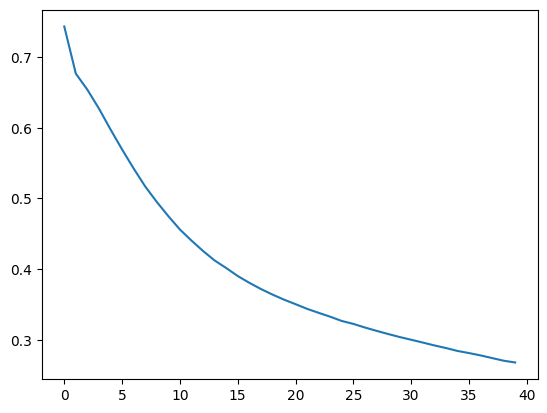

In [ ]:
test_model(learning_rate = 0.1,
           activation_function = MyReLU_mod,
           batch_size = 16)

#### Batch Size = $256$

Epoch 1/40: Train Loss = 0.9171, Accuracy = 0.5042
Epoch 2/40: Train Loss = 0.6949, Accuracy = 0.5060
Epoch 3/40: Train Loss = 0.6865, Accuracy = 0.5343
Epoch 4/40: Train Loss = 0.6853, Accuracy = 0.5780
Epoch 5/40: Train Loss = 0.6863, Accuracy = 0.5765
Epoch 6/40: Train Loss = 0.6837, Accuracy = 0.5762
Epoch 7/40: Train Loss = 0.6841, Accuracy = 0.5466
Epoch 8/40: Train Loss = 0.6816, Accuracy = 0.5863
Epoch 9/40: Train Loss = 0.6814, Accuracy = 0.5772
Epoch 10/40: Train Loss = 0.6786, Accuracy = 0.5768
Epoch 11/40: Train Loss = 0.6774, Accuracy = 0.5538
Epoch 12/40: Train Loss = 0.6761, Accuracy = 0.5661
Epoch 13/40: Train Loss = 0.6755, Accuracy = 0.5843
Epoch 14/40: Train Loss = 0.6740, Accuracy = 0.5687
Epoch 15/40: Train Loss = 0.6729, Accuracy = 0.5967
Epoch 16/40: Train Loss = 0.6729, Accuracy = 0.5940
Epoch 17/40: Train Loss = 0.6710, Accuracy = 0.5949
Epoch 18/40: Train Loss = 0.6700, Accuracy = 0.5891
Epoch 19/40: Train Loss = 0.6676, Accuracy = 0.5380
Epoch 20/40: Train Lo

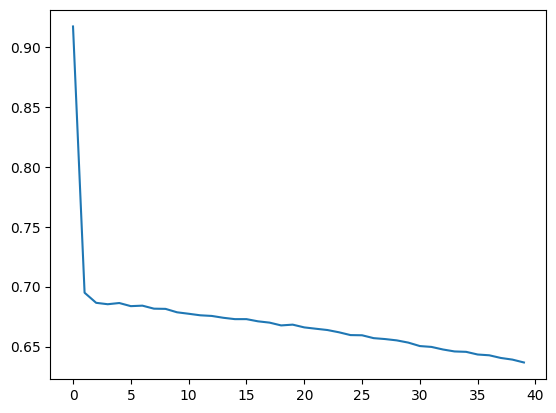

In [ ]:
test_model(learning_rate = 0.1,
           activation_function = MyReLU_mod,
           batch_size = 256)

The accuracy of the model with batch size 16 is higher, but the model with batch size 256 was the fastesr.